# My first Chatbot with Langgraph

In [1]:
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

api_key = os.getenv("GroqAPI")
llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=api_key)

In [5]:
#node functionality
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [6]:
graph_builder=StateGraph(State)
## its a chatbot node 
graph_builder.add_node("Myllm Chatbot",chatbot)
## these are the edges start and end

graph_builder.add_edge(START, "Myllm Chatbot")
graph_builder.add_edge("Myllm Chatbot", END)

## compile the graph
graph=graph_builder.compile()
graph_builder=StateGraph(State)

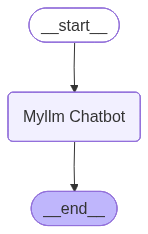

In [7]:
##visualize the Graph

from IPython.display import Image,display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
response=graph.invoke({"messages":"Hi"})

In [9]:
response["messages"][-1].content

"It's nice to meet you. Is there something I can help you with or would you like to chat?"

In [10]:
for event in graph.stream({"messages":"Hi How are you"}):
    for value in event.values():
        print(value['messages'][-1].content)

I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you might have. How about you? How's your day going so far?


# Use tools in Langgraph

In [11]:
from langchain_tavily import TavilySearch
tool = TavilySearch(tavily_api_key=os.getenv("TAVILY_API_KEY"), max_results=2)
tool.invoke("what is langgraph")


{'query': 'what is langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://huggingface.co/learn/agents-course/en/unit2/langgraph/when_to_use_langgraph',
   'title': 'What is LangGraph ? - Hugging Face Agents Course',
   'content': '# What is LangGraph ? `LangGraph` is a framework developed by LangChain **to manage the control flow of applications that integrate an LLM**. ## When should I use LangGraph ? `LangGraph` is on the other end of the spectrum, it shines when you need **“Control”** on the execution of your agent. LangGraph is particularly valuable when you need **Control over your applications**. It gives you the tools to build an application that follows a predictable process while still leveraging the power of LLMs. Put simply, if your application involves a series of steps that need to be orchestrated in a specific way, with decisions being made at each junction point, **LangGraph provides the structure you need**. ## How does L

In [12]:
def multiply(a:int,b:int)->int:
    """mutiply a and b
    
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [13]:
tools=[tool,multiply]

In [14]:
llm_with_tools=llm.bind_tools(tools)

In [15]:
llm_with_tools

RunnableBinding(bound=ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 32768, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x00000207A0D84FE0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000207A0EC99D0>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input

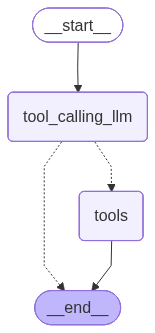

In [16]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## build edegs
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools",END)

graph=builder.compile()

from IPython.display import Image,display   
display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
response=graph.invoke({"messages":"what is the recent ai news"})

In [18]:
response['messages'][-1].content

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://patmcguinness.substack.com/p/ai-week-in-review-260207", "title": "AI Week in Review 26.02.07 - Substack", "score": 0.9750122, "published_date": "Sat, 07 Feb 2026 23:53:11 GMT", "content": "#### AI Research News\\n\\nThe ACE Studio team announced ACE-Step 1.5, a 4B parameter open-source AI music generator model capable of producing full songs with lyrics and style control in under ten seconds on consumer GPUs. The technical report “ACE-Step 1.5: Pushing the Boundaries of Open-Source Music Generation” details the model architecture and training. ACE-Step 1.5 combines a language-model (LM) planner and diffusion transformer (DiT) acoustic synthesizer, which enables fast local music generation. While scoring above commercial music generation models on SongEval benchmarks. [...] OpenAI released GPT-5.3-Codex, an agentic AI model designed to generate, debug, and reason over com

In [19]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (0afse7v94)
 Call ID: 0afse7v94
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://patmcguinness.substack.com/p/ai-week-in-review-260207", "title": "AI Week in Review 26.02.07 - Substack", "score": 0.9750122, "published_date": "Sat, 07 Feb 2026 23:53:11 GMT", "content": "#### AI Research News\n\nThe ACE Studio team announced ACE-Step 1.5, a 4B parameter open-source AI music generator model capable of producing full songs with lyrics and style control in under ten seconds on consumer GPUs. The technical report “AC

In [20]:
response=graph.invoke({"messages":"what is 2 multipy 3 is"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

what is 2 multipy 3 is
================================== Ai Message ==================================
Tool Calls:
  multiply (r3zy1kaq9)
 Call ID: r3zy1kaq9
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


# React Agent 

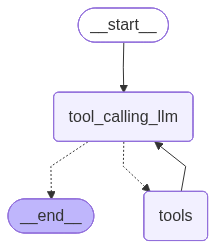

In [21]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node defination
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

## Graph 
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## build edegs
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)
builder.add_edge("tools","tool_calling_llm")

graph=builder.compile()

from IPython.display import Image,display   
display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
response=graph.invoke({"messages":"tell me ai news and what is 2 multipy 3 is"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

tell me ai news and what is 2 multipy 3 is
================================== Ai Message ==================================
Tool Calls:
  tavily_search (5k6tckz80)
 Call ID: 5k6tckz80
  Args:
    query: AI news
    search_depth: basic
    topic: general
  multiply (m15rf2h0d)
 Call ID: m15rf2h0d
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: tavily_search

{"query": "AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.reuters.com/technology/artificial-intelligence/", "title": "AI News | Latest Headlines and Developments", "content": "[Exclusive news, data and analytics for financial market professionalsLearn more aboutRefinitiv](/differentiator/). [Subscribe](https://www.reuters.com/account/subscribe/offer/&journeyStart=navigation). # Artificial Intelligence. How Artificial Intelligence is c